# Streaming Data Visualisation

In [1]:
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json


In [2]:
%matplotlib notebook

In [3]:
topic = 'Scenario01'
hostip = "192.168.0.129"

In [4]:
#Display the min and max at the line graph
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Celcius={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Celcius={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)


In [5]:
#Connect Kafka to retrieve data
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [6]:
#Create a consistent plotting environment with predefined settings 
#for a specific type of plot (air temperature against arrival time)
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Air Temperature Against Arrival Time') 
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (Celcius)')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [7]:
#Continuously consume messages, update the plot with the received data, and display the plot dynamically. 
#The plot is updated when there are more than 10 data points, 
#and the oldest data point is removed to maintain a fixed number of data points for visualization.

def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        for message in consumer:
            #Data Transformation for better input
            json_data = json.loads(message.value.decode('utf-8'))
            air_temp = int(json_data["air_temperature_celcius"])
            #Append transformed data to respective list
            x.append(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 
            y.append(air_temp)
            # Start plotting only when we have 10 data points
            if len(y) > 10:
              
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (Celcius)')
                ax.set_ylim(0,60) 
                ax.set_yticks([0,10,20,30,40,50,60])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


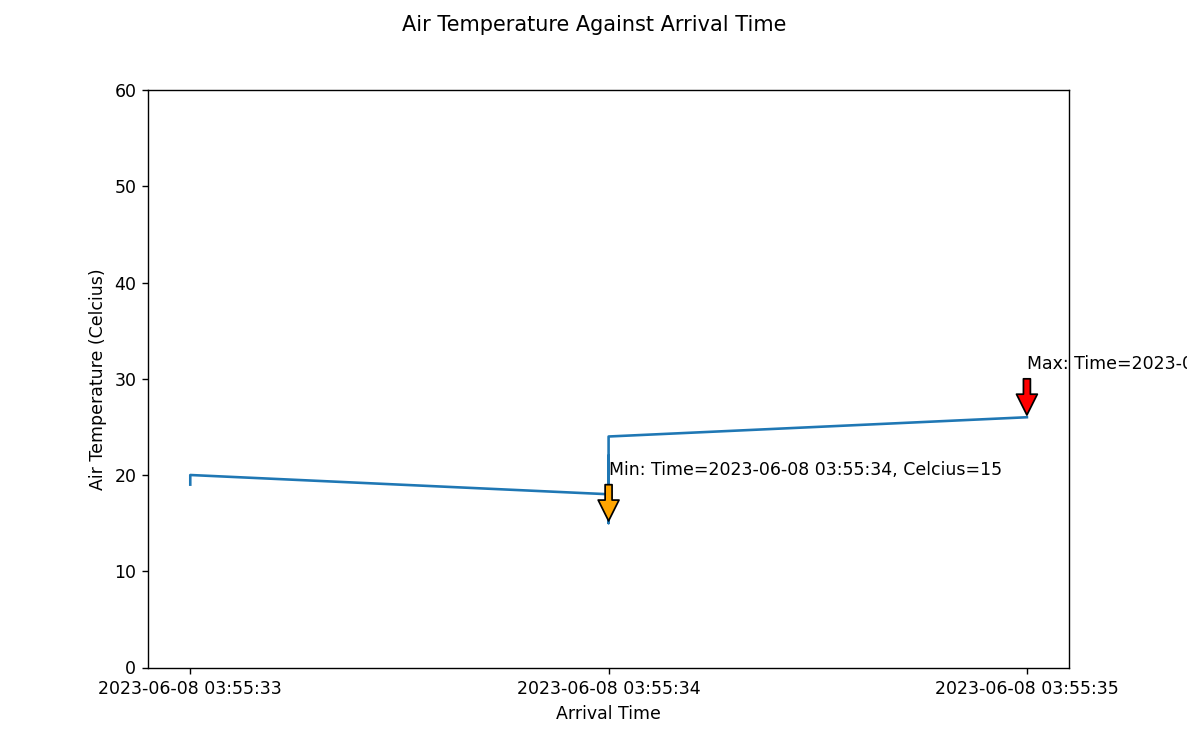

KeyboardInterrupt: 

In [8]:
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    

# Static Data Visualisation

## 1. Bar Plot

<IPython.core.display.Javascript object>


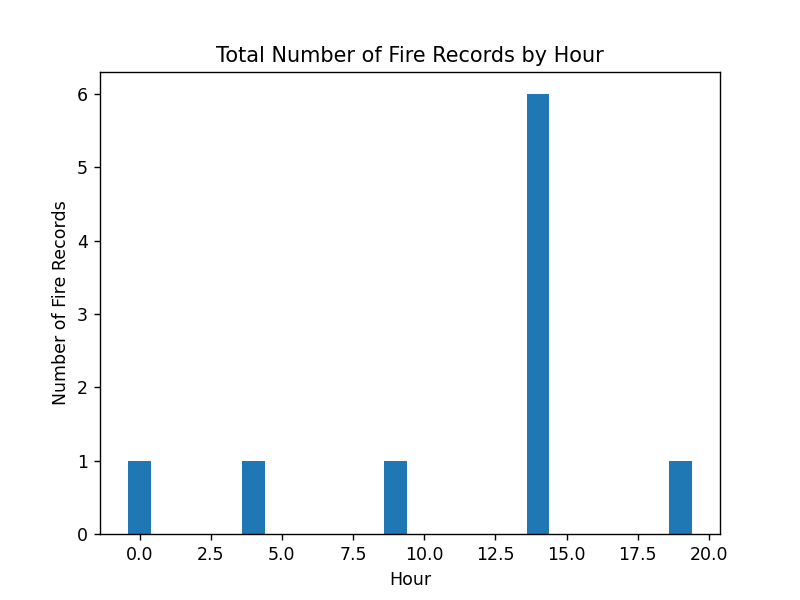

In [9]:
from pymongo import MongoClient
from datetime import datetime
from collections import Counter
host_ip = "192.168.0.129"

#Connect to mongodb and retrieve collection named PartB
client = MongoClient(host_ip, 27017)
db = client.fit3182_assignment_db
collection = db.PartB

hours = []
#Retrieve datetime and extract hour from it
for data_point in collection.find():
    if 'windspeed_knots' in data_point:
        continue
    dt = data_point['datetime']
    dt = datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S')

    # Retrieve the hour as an integer
    hour = dt.hour
    hours.append(hour)

#Count occurences of each hour
hour_counts = Counter(hours)

#Append hour and counter into respective list
r_hours=[]
counts = []
for hour, count in hour_counts.items():
    r_hours.append(int(hour))
    counts.append(int(count))

# Plot the bar chart
plt.bar(r_hours, counts)
plt.xlabel("Hour")
plt.ylabel("Number of Fire Records")
plt.title("Total Number of Fire Records by Hour")
plt.show()

## 2. Map

In [10]:
# !pip install folium
import folium
from pymongo import MongoClient
host_ip = "192.168.0.129"

client = MongoClient(host_ip, 27017)
db = client.fit3182_assignment_db
collection = db.PartB

m = folium.Map(location=[-36.9848, 143.3906], zoom_start=7)

for data_point in collection.find():
        if 'windspeed_knots' in data_point:
            continue
        
        #Locate parent document
        parent_doc = collection.find({'geohash_value': data_point['hotspot_geohash_value']})
        
        #Retrieve attribute from parent document
        for doc in parent_doc:
            parent_air_temp = doc['air_temperature_celcius']
            parent_relative_humidity = doc['relative_humidity']
        
        #Assignment relevant attribute from child and parent documents
        lat = data_point['latitude']
        lon = data_point['longitude']
        cause = data_point['fire_event']
        air_temp = parent_air_temp
        surface_temp = data_point['surface_temperature_celcius']
        humidity = parent_relative_humidity
        confidence = data_point['confidence']
        
        if cause == 'natural':
            color = 'blue'
        else:
            color = 'red'
        #Plot map with custom tooltip
        folium.Marker(location=[lat, lon],
                  icon=folium.Icon(color=color),
                  tooltip=f"Air Temp: {air_temp}°C\nSurface Temp: {surface_temp}°C\nHumidity: {humidity}%\nConfidence: {confidence}").add_to(m)


In [11]:
m